In [1]:
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.ndimage import zoom
from utils import calculate_metric_percase
from networks.TransUNet_model import TransUNet
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

cudnn.benchmark = False
cudnn.deterministic = True

random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2021)
torch.cuda.manual_seed(2021)

In [2]:
! ls /ssd_scratch/cvit/rupraze/data/ultrasound/training_set | head -n2
! ls /ssd_scratch/cvit/rupraze/data/lungs_seg_dataset/images_bcet | head -n2

000_HC.png
001_HC.png
ls: write error: Broken pipe
00000265_nCoV-Snohomish-20382862_web1_M1-Lungs-EDH-200201-640x300@2x.npy
00000301_person88_virus_164.npy
ls: write error: Broken pipe


In [3]:
ultrasound_model_path = '/ssd_scratch/cvit/rupraze/models/US_scratch_nonscat_weights/epoch_140.pth'
xray_model_path = '/ssd_scratch/cvit/rupraze/models/lung_scratch_model/epoch_120.pth'

ultrasound_scat_model_path = '/ssd_scratch/cvit/rupraze/models/US_scratch_scat_model/epoch_60.pth'
xray_scat_model_path = '/ssd_scratch/cvit/rupraze/models/lung_scratch_scat_model/epoch_140.pth'

## specify which data set  and model to use

In [4]:
dataset_name = 'LungSeg'
use_scat_encoder = False

img_size = 224

if use_scat_encoder:
    from datasets.dataset_us_xray_scat import Ultrasound_dataset, LungXray_dataset
    model_path = { 'Ultrasound':ultrasound_scat_model_path, 'LungSeg':xray_scat_model_path}
else:
    from datasets.dataset_us_xray import Ultrasound_dataset, LungXray_dataset
    model_path = { 'Ultrasound':ultrasound_model_path, 'LungSeg':xray_model_path}

In [5]:
dataset_config = {
    'Ultrasound': {
        'Dataset': Ultrasound_dataset,
        'root_path': '/ssd_scratch/cvit/rupraze/data/ultrasound',
        'list_dir': './lists/lists_Ultrasound',
        'num_classes': 2,
    },
    'LungSeg': {
        'Dataset': LungXray_dataset,
        'root_path': '/ssd_scratch/cvit/rupraze/data/lungs_seg_dataset',
        'list_dir': './lists/lists_CovidLungSeg',
        'num_classes': 2,
    },
}

num_classes = dataset_config[dataset_name]['num_classes']
root_path = dataset_config[dataset_name]['root_path']
Dataset = dataset_config[dataset_name]['Dataset']
list_dir = dataset_config[dataset_name]['list_dir']

## Load TransUNet

In [6]:
net = TransUNet(num_classes=num_classes, use_scat_encoder=use_scat_encoder).cuda()
net.load_state_dict(torch.load(model_path[dataset_name]))

<All keys matched successfully>

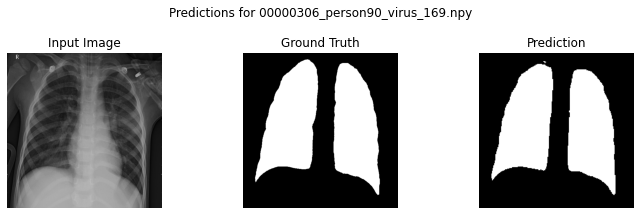

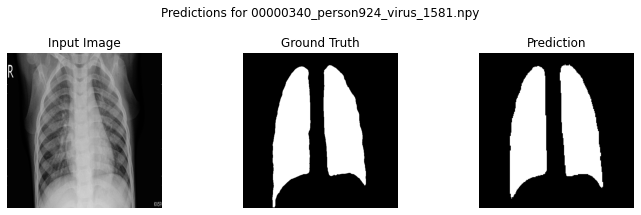

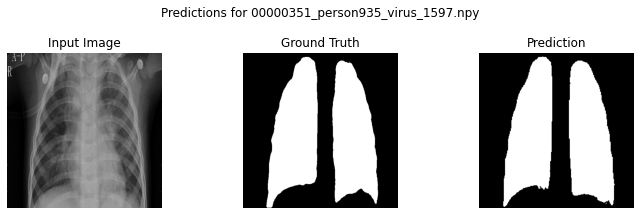

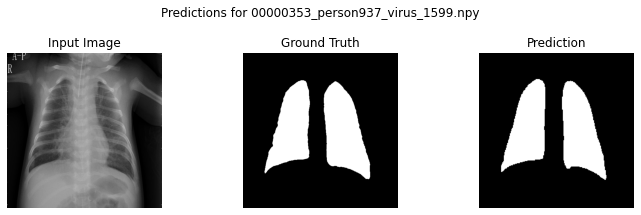

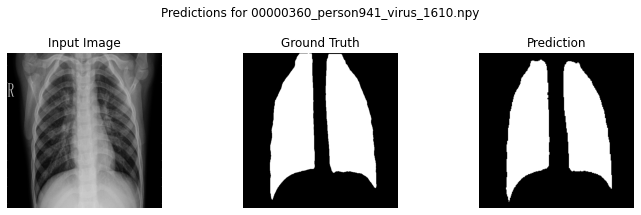

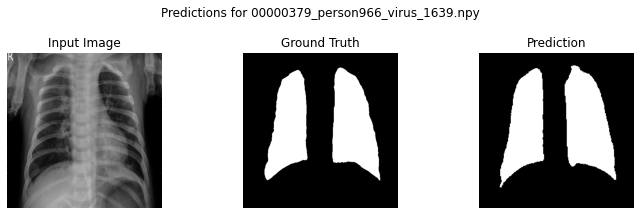

In [7]:
db_test = Dataset(base_dir=root_path, split="test_vol", list_dir=list_dir)
testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=1)

net.eval()

for i_batch, sampled_batch in enumerate(testloader):
    h, w = sampled_batch["image"].size()[2:]
    image, label, case_name = sampled_batch["image"], sampled_batch["label"], sampled_batch['case_name'][0]
    if use_scat_encoder:
        scat_mat_batch = sampled_batch['scat_mat']
        scat_mat_batch = scat_mat_batch.cuda()
    else:
        scat_mat_batch = None
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    disp_image = np.copy(image)
    patch_size = [img_size,img_size]
    prediction = np.zeros_like(label)
    
    slice = image[0, :, :]
    x, y = slice.shape[0], slice.shape[1]
    if x != patch_size[0] or y != patch_size[1]:
        slice = zoom(slice, (patch_size[0] / x, patch_size[1] / y), order=3)
    
    input = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()
    net.eval()
    with torch.no_grad():
        outputs = net(input, scat_mat_batch)
        out = torch.argmax(torch.softmax(outputs, dim=1), dim=1).squeeze(0)
        out = out.cpu().detach().numpy()
        if x != patch_size[0] or y != patch_size[1]:
            pred = zoom(out, (x / patch_size[0], y / patch_size[1]), order=0)
        else:
            pred = out
        prediction[0] = pred
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle('Predictions for '+str(case_name))
    ax1.imshow(disp_image[0, :, :], cmap='gray')
    ax1.set_title('Input Image')
    ax1.axis('off')
    ax2.imshow(label[0,:,:], cmap='gray')
    ax2.set_title('Ground Truth')
    ax2.axis('off')
    ax3.imshow(pred, cmap='gray')
    ax3.set_title('Prediction')
    ax3.axis('off')
    plt.tight_layout()
    plt.show()
    if i_batch>4:
        break